# Introduction to single-cell RNA-seq II: getting started with analysis

Paper: https://science-sciencemag-org.clsproxy.library.caltech.edu/content/371/6530/eabd9704/tab-pdf  
Supp.: https://science.sciencemag.org/content/sci/suppl/2021/02/10/371.6530.eabd9704.DC1/abd9704_Colquitt_SM.pdf  
Tutorial: https://www.kallistobus.tools/tutorials/kb_getting_started/python/kb_intro_2_python/

This notebook demonstrates pre-processing and basic analysis of the mouse retinal cells GSE126783 dataset from Koren et al., 2019. Following pre-processing using kallisto and bustools and basic QC, the notebook demonstrates some initial analysis. The approximate running time of the notebook is about 13 minutes.

The notebook was written by Kyung Hoi (Joseph) Min, A. Sina Booeshaghi and Lior Pachter. If you use the methods in this notebook for your analysis please cite the following publications which describe the tools used in the notebook, as well as specific methods they run (these are cited inline in the notebook):

Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285
Wolf, F. A., Angere, P. and Theis, F.J. SCANPY: large-scale single-cell gene expression data analysis. Genome Biology (2018). doi:10.1186/s13059-017-1382-0
An R notebook implementing the same analysis is available here. See the kallistobus.tools tutorials site for additional notebooks demonstrating other analyses.

# Setup

In [1]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

# Install and import python packages

In [2]:
# # These packages are pre-installed on Google Colab, but are included here to facilitate running this notebook locally
# !pip install --quiet matplotlib
# !pip install --quiet scikit-learn
# !pip install --quiet numpy
# !pip install --quiet scipy

In [3]:
# %%time
# # `kb` is a wrapper for the kallisto and bustools program, and the kb-python package contains the kallisto and bustools executables.
# !pip install --quiet kb-python==0.24.1

In [4]:
# !pip install numba

In [5]:
# %%time
# # Install scanpy and other packages needed for single-cell RNA-seq analysis
# !pip install --quiet scanpy python-igraph louvain MulticoreTSNE pybiomart

In [6]:
# Import packages
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

# Download the data
Note: We use the -O option for wget to rename the files so they can be easily identified. The notebook requires reads in fastq format; the files can be processed in gzip compressed format.

In this example the reads are downloaded from a Box drive; see the data download notebook for information on where to find publicly available single-cell RNA-seq data.

In [7]:
# %%time
# !wget -q https://caltech.box.com/shared/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt -O checksums.txt
# !wget -q https://caltech.box.com/shared/static/w9ww8et5o029s2e3usjzpbq8lpot29rh.gz -O SRR8599150_S1_L001_R1_001.fastq.gz
# !wget -q https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz -O SRR8599150_S1_L001_R2_001.fastq.gz

# kb

## Build index:

In [8]:
# %%time
# !kb ref -i index.idx -g t2g.txt -f1 cdna.fa \
# Taeniopygia_guttata.bTaeGut1_v1.p.dna.toplevel.fa.gz \
# Taeniopygia_guttata.bTaeGut1_v1.p.104.gtf.gz

#### Build index with nucleus setting

In [9]:
# kb ref -i index_nucleus.idx -g t2g_nucleus.txt -f1 cdna_nucleus.fa -f2 introns.fa -c1 cDNA_t2c.txt -c2 intron_t2c.txt --workflow=nucleus Taeniopygia_guttata.bTaeGut1_v1.p.dna.toplevel.fa Taeniopygia_guttata.bTaeGut1_v1.p.104.gtf

## Pseudoalignment and counting
Run kallisto and bustools  
The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store Anndata objects. Notice that this requires providing the index and transcript-to-gene mapping downloaded in the previous step to the -i and -g arguments respectively. Also, since the reads were generated with the 10x Genomics Chromium Single Cell v3, the -x 10xv3 argument is used. 

### Added "--filter bustools"   
I ran below code on the terminal. The filtering only worked after downloading the most recent kb version. The latest version did not download/update automatically (pip downloaded an older version).

In [10]:
# %%time
# # This step runs `kb` to pseudoalign the reads, and then generate the cells x gene matrix in h5ad format.
# !kb count --filter bustools -i index.idx -g t2g.txt -x 10xv3 --h5ad -t 8 -o "hvc1_kallisto"\
# SRR12130197_1.fastq.gz \
# SRR12130197_2.fastq.gz

Same for the HVC experiment 3 dataset:

In [11]:
# %%time
# # This step runs `kb` to pseudoalign the reads, and then generate the cells x gene matrix in h5ad format.
# !kb count --filter bustools -i index.idx -g t2g.txt -x 10xv3 --h5ad -t 8 -o "hvc3_kallisto"\
# SRR12130199_1.fastq.gz \
# SRR12130199_2.fastq.gz

Ran on Terminal (this was before fastq files were renamed for cellranger):

In [12]:
# kb count --filter bustools -i index.idx -g t2g.txt -x 10xv3 --h5ad -t 8 -o hvc1_kallisto SRR12130197_1.fastq.gz SRR12130197_2.fastq.gz  

In [13]:
# kb count --filter bustools -i index.idx -g t2g.txt -x 10xv3 --h5ad -t 8 -o hvc3_kallisto SRR12130199_1.fastq.gz SRR12130199_2.fastq.gz

#### Pseudoalignment & counting with nucleus setting:  

In [14]:
## For HVC1
# kb count \
# --filter bustools \
# -i ./kallisto_nucleus/index_nucleus.idx \
# -g ./kallisto_nucleus/t2g_nucleus.txt \
# -x 10xv3 \
# -c1 cDNA_t2c.txt \
# -c2 intron_t2c.txt \
# --h5ad \
# -t 8 \
# -o ./kallisto_nucleus/hvc1_kallisto_nucleus \
# ./hvc1_fastq/SRR12130197_S1_L001_R1_001.fastq.gz \
# ./hvc1_fastq/SRR12130197_S1_L001_R2_001.fastq.gz

In [ ]:
# ## For HVC2
# kb count \
# --filter bustools \
# -i ./kallisto_nucleus/index_nucleus.idx \
# -g ./kallisto_nucleus/t2g_nucleus.txt \
# -x 10xv3 \
# -c1 cDNA_t2c.txt \
# -c2 intron_t2c.txt \
# --h5ad \
# -t 8 \
# -o ./kallisto_nucleus/hvc2_kallisto_nucleus \
# ./hvc2_fastq/SRR12130198_1.fastq.gz \
# ./hvc2_fastq/SRR12130198_2.fastq.gz

In [15]:
## For HVC3
# kb count \
# --filter bustools \
# -i ./kallisto_nucleus/index_nucleus.idx \
# -g ./kallisto_nucleus/t2g_nucleus.txt \
# -x 10xv3 \
# -c1 cDNA_t2c.txt \
# -c2 intron_t2c.txt \
# --h5ad \
# -t 8 \
# -o ./kallisto_nucleus/hvc3_kallisto_nucleus \
# ./hvc3_fastq/SRR12130197_S1_L001_R1_001.fastq.gz \
# ./hvc3_fastq/SRR12130197_S1_L001_R2_001.fastq.gz

#### Import filtered and unfiltered data

In [16]:
# import HVC 1 unfiltered data
adata_hvc1_uf = anndata.read('kallisto_normal/hvc1_kallisto/counts_unfiltered/adata.h5ad')
adata_hvc1_uf

AnnData object with n_obs × n_vars = 925666 × 22150
    var: 'gene_name'

In [17]:
# import HVC 1 filtered data
adata_hvc1_f = anndata.read('kallisto_normal/hvc1_kallisto/counts_filtered/adata.h5ad')
adata_hvc1_f

AnnData object with n_obs × n_vars = 36297 × 22150
    var: 'gene_name'

In [19]:
# import HVC 3 unfiltered data
adata_hvc3_uf = anndata.read('kallisto_normal/hvc3_kallisto/counts_unfiltered/adata.h5ad')
adata_hvc3_uf

AnnData object with n_obs × n_vars = 925999 × 22150
    var: 'gene_name'

In [20]:
# import HVC 3 filtered data
adata_hvc3_f = anndata.read('kallisto_normal/hvc3_kallisto/counts_filtered/adata.h5ad')
adata_hvc3_f

AnnData object with n_obs × n_vars = 43931 × 22150
    var: 'gene_name'

# CellRanger

FASTA and genes files unzipped using "gunzip" command in terminal.

Note: The data analyst in the zebrafinch scseq paper possibly ran "cellranger mkgtf" with variable "--attribute=gene_biotype:protein_coding" thereby creating a minimal GTF containing only exon information. (Does this explain 0% alignment to intronic sequences in Table S1?)

Build CellRanger index (in terminal):

In [ ]:
# cellranger mkref --genome=Taeniopygia_guttata_genome \
# --fasta=Taeniopygia_guttata.bTaeGut1_v1.p.dna.toplevel.fa \
# --genes=Taeniopygia_guttata.bTaeGut1_v1.p.104.gtf \
# --nthreads=8

See info from this run in "Log.out" file.

##### In order to run the below command, the fastq files need to be renamed according to SampleName_S1_L001_R1_001 !!!

In [ ]:
# cellranger count \
# --id=hvc1_cellranger \
# --transcriptome=cellranger_unfiltered/Taeniopygia_guttata_genome \
# --fastqs=hvc1_fastq

In [ ]:
# cellranger count \
# --id=hvc3_cellranger \
# --transcriptome=cellranger_unfiltered/Taeniopygia_guttata_genome \
# --fastqs=hvc3_fastq

### Test if building GTF with variable mentioned above gets rid of intron alignments:

Filter GTF:

In [ ]:
# cellranger mkgtf Taeniopygia_guttata.bTaeGut1_v1.p.104.gtf Taeniopygia_guttata.bTaeGut1_v1.p.104.filtered.gtf --attribute=gene_biotype:protein_coding

Build CellRanger index using filtered gtf:

In [ ]:
# cellranger mkref --genome=Taeniopygia_guttata_genome_filtered \
# --fasta=Taeniopygia_guttata.bTaeGut1_v1.p.dna.toplevel.fa \
# --genes=Taeniopygia_guttata.bTaeGut1_v1.p.104.filtered.gtf \
# --nthreads=8

In [ ]:
# cellranger count --id=hvc1_cellranger_filtered --transcriptome=./cellranger_gtf-filtered/Taeniopygia_guttata_genome_filtered --fastqs=hvc1_fastq

In [ ]:
# cellranger count --id=hvc3_cellranger_filtered --transcriptome=./cellranger_gtf-filtered/Taeniopygia_guttata_genome_filtered --fastqs=hvc3_fastq

In [ ]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(adata_hvc1_uf.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata_hvc1_uf.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))


plt.show()

The below returns an empty list for both ggallus and hsapiens (no reference exists for tguttata). This means that none of the identified mitochondrial gene names occur in the zebrafinch ref genome.

In [ ]:
# mito_ensembl_names = sc.queries.mitochondrial_genes("ggallus", attrname="external_gene_name")
# np.where(adata_hvc1_uf.var["gene_name"].isin(mito_ensembl_names["external_gene_name"].values))

I will instead find all gene names that start with "MT". I am not sure whether all of these are actually mitochondrial genes.

In [ ]:
# Find all gene indices startng with "MT"
df = np.where(adata_hvc1_uf.var["gene_name"].str.startswith("MT")==True)

In [ ]:
# Show all genes startng with "MT" - Are the mitochondrial genes???
mito_genes = adata_hvc1_uf.var["gene_name"].iloc[df]
mito_genes

In [ ]:
mito_ids = mito_genes.index.values

In [ ]:
adata_hvc1_uf.var["gene_id"] = adata_hvc1_uf.var.index.values

In [ ]:
adata_hvc1_uf.var

In [ ]:
adata_hvc1_uf.var["mito"] = False
adata_hvc1_uf.var.loc[(adata_hvc1_uf.var["gene_id"].isin(mito_ids) ==True), "mito"] = True

In [ ]:
adata_hvc1_uf.var

In [21]:
# mito_genes = mito_gene_ids.values
# # for each cell compute fraction of counts in mito genes vs. all genes
# # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# adata_hvc1_uf.obs['percent_mito'] = np.sum(
#     adata_hvc1_uf[:, mito_genes].X, axis=1).A1 / np.sum(adata_hvc1_uf.X, axis=1).A1
# # add the total counts per cell as observations-annotation to adata
# adata_hvc1_uf.obs['n_counts'] = adata_hvc1_uf.X.sum(axis=1).A1

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

# Build atlas for HVC1 using bustool filtered Kallisto (normal) matrix

Expected number of cells for HVC1: 10554 (from Table S1 seq-stats)

In [18]:
adata = adata_hvc1_f
adata

Test for library saturation:

# Legend of the heatmap???

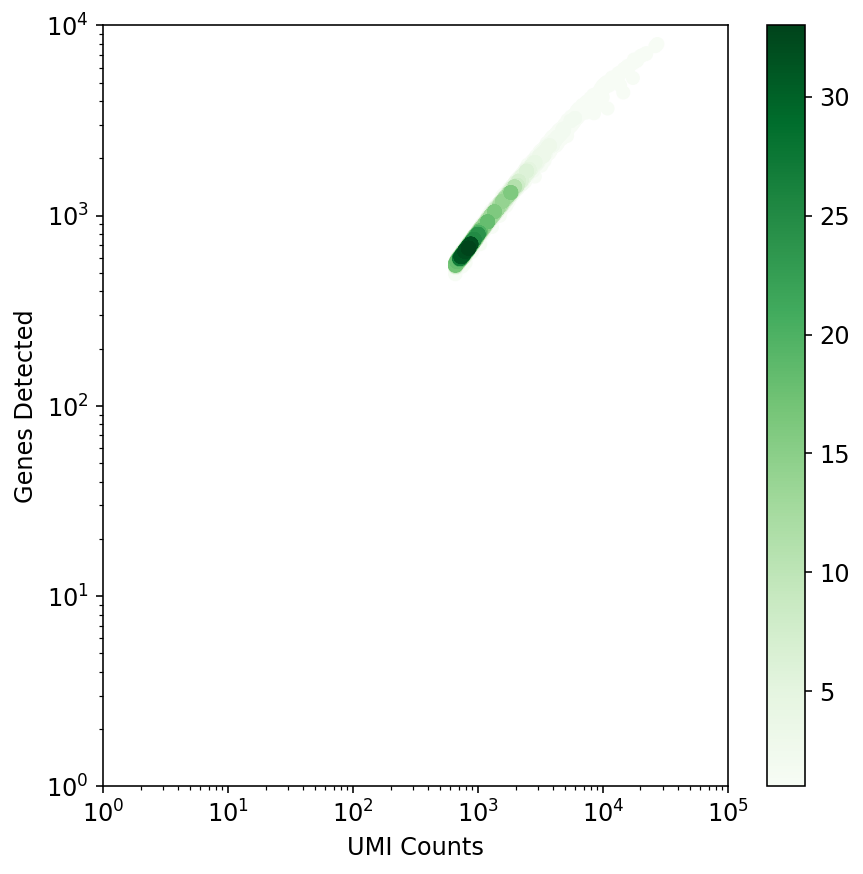

In [25]:
fig, ax = plt.subplots(figsize=(7,7))

#histogram definition
bins = [1500, 1500] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]


s = ax.scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")

ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)

plt.show()

#### Knee plot

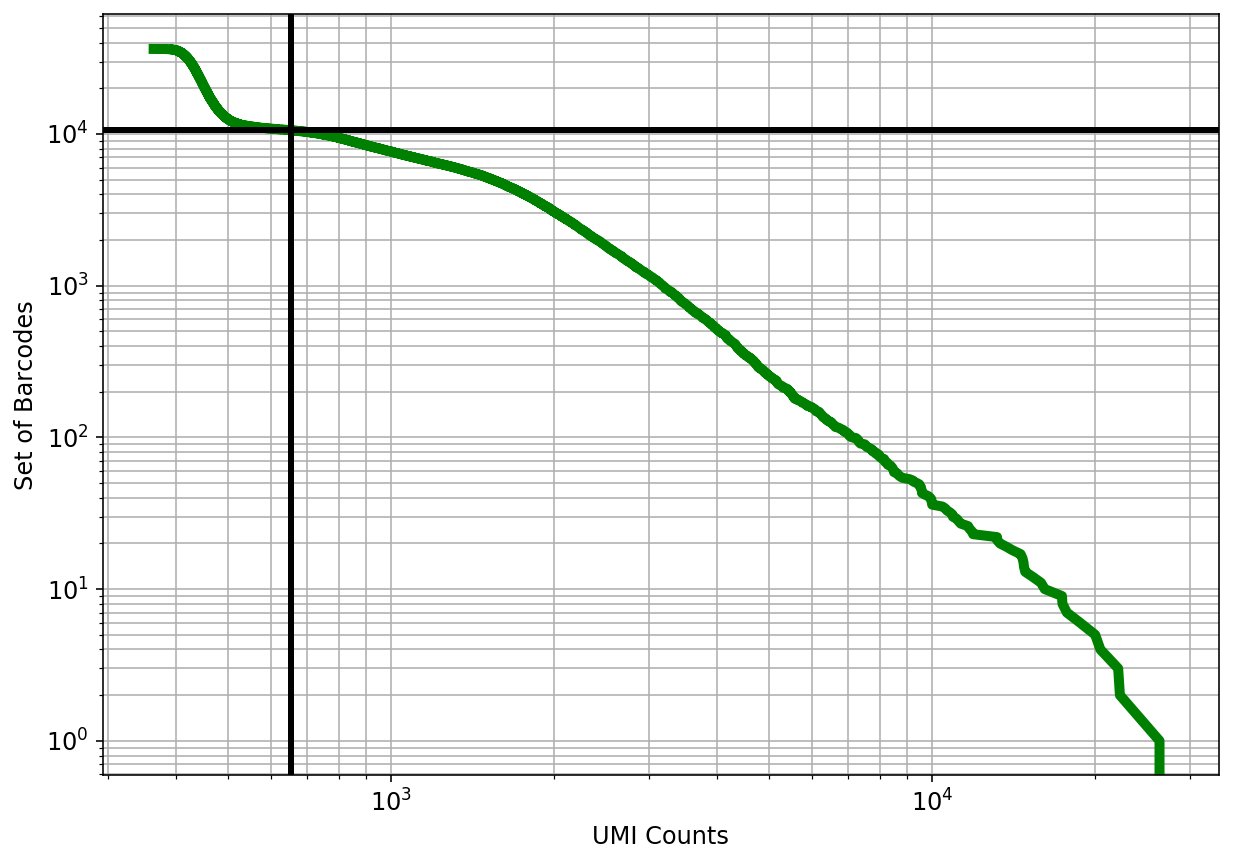

In [19]:
expected_num_cells =  10554
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

### Filtering

Minimum number of UMI counts based on knee plot:

In [20]:
min_umi = knee[expected_num_cells]
min_umi

654.0

In [21]:
# Copy index into column
adata.var["gene_id"] = adata.var.index.values

In [22]:
# Removes cells with less than min_umi umi counts
adata = adata[np.asarray(adata_hvc1_f.X.sum(axis=1)).reshape(-1) > min_umi]

# Removes genes with 0 umi counts
adata = adata[:, np.asarray(adata_hvc1_f.X.sum(axis=0)).reshape(-1) > 0]

In [23]:
adata

View of AnnData object with n_obs × n_vars = 10554 × 20114
    var: 'gene_name', 'gene_id'

This is pretty close to the expected number of cells (approx 10k).

Compute n_count (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):

In [29]:
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [30]:
adata

AnnData object with n_obs × n_vars = 10554 × 20114
    obs: 'n_counts'
    var: 'gene_name', 'gene_id'